# `Predicting outcomes for pedestrians`<br>
Baseline, Hypothesis testing for feature selection and model improvement

In this notebook, we want to assess how well our model perform to predict the inrjury level for pedestrians. We will improve the model by adding hypothesis testing for feature selection and try to improve our score

In [293]:
#Importing data manipulation and visualization libraries
import pandas as pd # for dataframe manipulation
import numpy as np # for numbers manipulations


import seaborn as sns # for data visualization
import matplotlib.pyplot as plt # for data visualization
import scipy.stats as stats # # we never just "import scipy" as all the juice is in the submodules

import plotly.express as px # for data visualization
import plotly.figure_factory as ff# for data visualization

from sklearn.preprocessing import LabelEncoder,FunctionTransformer,StandardScaler #for data preprocessing and scaling
from sklearn.feature_selection import chi2 #for hypothesis testing on categorical variables
from sklearn.pipeline import Pipeline #for chaining operations prior to the gridsearch

from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV #for modeling preparation

#importing our models
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier, plot_importance

#importing metrics to evaluate models performance
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import precision_score, recall_score, roc_auc_score, accuracy_score,f1_score,confusion_matrix,ConfusionMatrixDisplay, RocCurveDisplay, plot_roc_curve 
from imblearn.metrics import specificity_score

import warnings
warnings.filterwarnings("ignore")

# to access AWS
import aws_creds
import os
from smart_open import smart_open
import boto3 
from io import StringIO # python3; python2: BytesIO 

#check time it takes to run the entire notebook
import time
st = time.time()

Helper functions

In [241]:
#this function will fit models and generate visualization
def meta_func (model,model_name,param_grid,X_train,y_train,X_test,y_test,score_dict):
        #model
        gs_model = GridSearchCV(
        model,
        param_grid=param_grid,
        cv=3,
        verbose=1,
        n_jobs=-1
        )

        #fitting model -------------------------------------------------------
        gs_model.fit(X_train,y_train)

        #getting predictions
        train_preds = gs_model.predict(X_train)
        preds = gs_model.predict(X_test)
        
        #getting the test metrics ready
        test_f1score=f1_score(y_test,preds)
        test_precision=precision_score(y_test,preds)
        test_accuracy=accuracy_score(y_test,preds)
        test_recall=recall_score(y_test,preds)
        test_roc_auc=roc_auc_score(y_test,preds)
        test_specificity = specificity_score(y_test,preds)

        #getting the train metrics
        train_f1score=f1_score(y_train,train_preds)
        train_specificity = specificity_score(y_train,train_preds)
        train_precision=precision_score(y_train,train_preds)
        train_accuracy=accuracy_score(y_train,train_preds)
        train_recall=recall_score(y_train,train_preds)
        train_roc_auc=roc_auc_score(y_train,train_preds)
        #printing results-----------------------------------------------------------------

        print(f'best params : {gs_model.best_params_}')

        print(f'Test_f1_score : {test_f1score}')
        print(f'Test_precision score : {test_precision}')
        print(f'Test_accuracy score : {test_accuracy}')
        print(f'Test_recall score : {test_recall}')
        print(f'Test_roc_auc score : {test_roc_auc}')
                
        # #update various metrics onto results list-------------------------------------------------------------
        score_dict[model_name] = {
                'Train_acc':train_accuracy,
                'Test_acc':test_accuracy,
                'Train_recall':train_recall,
                'Test_recall':test_recall,
                'Train_preci':train_precision,
                'Test_preci':test_precision,
                'Train_f1score':train_f1score,
                'Test_f1score':test_f1score,
                'Train_roc_auc':train_roc_auc,
                'Test_roc_auc':test_roc_auc,
                'Train_specificity': train_specificity,
                'Test_specificity':test_specificity
                }

        tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
        cm = confusion_matrix(y_test,preds)
        displ = ConfusionMatrixDisplay(cm)
        displ.plot();

        plot_roc_curve(gs_model.best_estimator_, X_test, y_test)
        plt.plot([0, 1], [0, 1],
        label='baseline', linestyle='--') # to simulate random guess 
        plt.legend();

        return gs_model

In [242]:
#Helper functions - showing dataframe quality
def df_quality (df):
    df_qual= pd.DataFrame(df.dtypes, columns={'dtypes'}) # creating a colum to display all data types
    df_qual['isna%'] = np.round((df.isna().sum()/len(df))*100,1) # creating new columns = to missing values %
    df_qual['isna']= df.isna().sum()
    df_qual['unique']=df.nunique() # creating new columns eq to missing values
    return df_qual.sort_values(by= 'isna%' , ascending=False)[:40] # sorting and shortlisting

In [243]:
#function to test for statistical significance, and chosing the right test depending on data distribution
#borrowed from Shilpa's github  -https://github.com/shilpaleo/employee_resignation_prediction/blob/main/notebook/Resignation%20Case%20Study.ipynb
def cont_stat_sig_test(df,col):
    # defining function for normality + statistical significance check
    # Step 1: normality test
    stat, p_value = stats.normaltest(df[col].values)
    
    # Step 2: filter series    
    df_ok = df[df['injury_level']=='OK'][col].values
    df_not_ok = df[df['injury_level']=='not_ok'][col].values
    
    # Step 3: determining appropriate statistical significance test based on normality
    if p_value>0.01:
        distribution = 'normal distribution'
        test = 'Anova test'
        stat, p_value = stats.f_oneway(df_ok, df_not_ok)
    
    else:
        distribution = 'non-normal distribution'
        test = 'KS test'
        stat, p_value = stats.ks_2samp(df_ok, df_not_ok)
    
    # Step 4: conclude on statistical significance
    if p_value>0.05:
        sig = 'not statistically significant'
    else:
        sig = 'statistically significant'

    print(f'{col} has {distribution}: running {test}. result: {sig}')
    return p_value


In [244]:
#dictionary to store our results
score_dict_pedestrians={}

### 1. Preping data for 1st run

Importing file

In [245]:
aws_key = aws_creds.aws_key
aws_secret = aws_creds.aws_secret

bucket_name = aws_creds.bucket
object_key = 'df_eda.csv'

path = 's3://{}:{}@{}/{}'.format(aws_key, aws_secret, bucket_name, object_key)

df = pd.read_csv(smart_open(path),index_col=[0])

In [246]:
df['injury_level'] = df['injury_level'].map({'OK':1,'not_ok':0}) #mapping target variable
df_pede = df[(df['user_type']=='pedestrian')]
df_pede['injury_level'].value_counts()

1    19295
0     9634
Name: injury_level, dtype: int64

In [247]:
df_quality (df_pede)

,dtypes,isna%,isna,unique
fixed_obstacle_hurt,object,94.1,27226,14
reserved_path,object,87.7,25372,2
infra_type,object,82.4,23847,9
safety_feat_2,object,73.2,21171,3
width_road_only,object,38.6,11177,75
safety_feat_1,object,30.5,8809,3
journey_reason,object,28.5,8256,6
lane_num,object,15.9,4590,11603
engine_type,object,13.0,3766,6
navigation_direction,object,9.7,2801,3


Let's clear the NaN before fitting models. Given the NaNs identified above and the information contained in the columns, we make the choice to cut any feature with more than 10% NaN

In [248]:
#Let's remove all 10% above NaN features
high_nans = [col for col in df_pede.columns if ((df_pede[col].isna().sum()/len(df_pede)))>0.1]
df_pede = df_pede.drop(columns = high_nans)

#then we drop any columns with NaNs remaining 
print(f'after dropping high_nan features, shape is : {df_pede.shape}')
df_pede = df_pede.dropna()
print(f'after dropping high_nan and remaining nan, shape is: {df_pede.shape}')

#finally, we manually renmove these columns as they are either duplicates or strongly correlated to other features
pede_cols_todrop = [
    'acc_num', # not informative 
    'id_vehicule', #not informative
    'seat',#only valid for pedestrians and pedestrians
    #'user_type',# already filtered on pedestrians + pedestrians
    'day',#duplicate with day of the week and month
    'year',# dropping year but keeping month for seasonality
    'lat',#duplicate with geo
    'long', #duplicate with geo
    'date',#duplicate with day of the week and Month - we do not need that much details
    'hhmm',#already captured in hh
    'YYYY-MM',#another date duplicate only used for EDA
    'country',#not informative
    #'lane_num',
    'max_speed_allowed', # we are going with speed_group instead
    'city',
    'age',
    'geo',
    'dob',
    'postal_address',
    'department_fr']

df_pede = df_pede.drop(columns = pede_cols_todrop)
print(f'after dropping duplicates, final shape is : {df_pede.shape}')

after dropping high_nan features, shape is : (28929, 49)
after dropping high_nan and remaining nan, shape is: (19401, 49)
after dropping duplicates, final shape is : (19401, 31)


In [249]:
df_quality(df_pede)

,dtypes,isna%,isna,unique
user_type,object,0.0,0,1
road_curve,object,0.0,0,4
vehi_grp,object,0.0,0,3
speed_group,float64,0.0,0,7
event,object,0.0,0,12
hour,int64,0.0,0,24
day_of_week,object,0.0,0,7
collision_type,object,0.0,0,7
weather,object,0.0,0,9
crossing,object,0.0,0,5


In [250]:
#preparing our X and y
X = df_pede.drop(columns='injury_level')
y=df_pede['injury_level']

In [251]:
#encoding categorical variables
X = pd.get_dummies(X, columns=X.select_dtypes('object').columns, drop_first=True)
X_train,X_test,y_train,y_test = train_test_split(X,y, random_state=42, test_size=0.2, stratify=y)
print(X.shape)

(19401, 142)


### 2. Modeling

#### Logistic Regression

Fitting 3 folds for each of 4 candidates, totalling 12 fits
best params : {'lr__C': 0.2, 'lr__class_weight': 'balanced', 'lr__penalty': 'l1'}
Test_f1_score : 0.7537567621719095
Test_precision score : 0.8035027765912004
Test_accuracy score : 0.6833290389074981
Test_recall score : 0.709811320754717
Test_roc_auc score : 0.6680656928712658
CPU times: total: 4.61 s
Wall time: 17.2 s


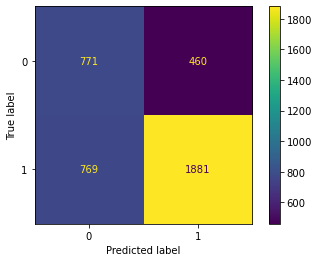

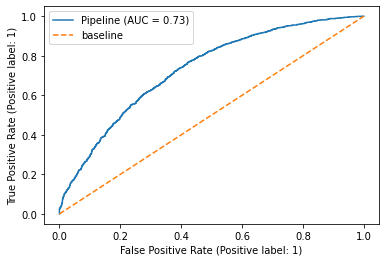

In [252]:
%%time
model = meta_func (
    model=
        Pipeline(
    [
    ('ss',StandardScaler()),
    ('lr', LogisticRegression(random_state=42, solver='saga'))
    ]
)
,
    model_name='lr_1st_round',
    param_grid=
    {"lr__penalty":['l1','l2'],
    "lr__C":[0.2,0.3],#Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.
    "lr__class_weight":['balanced']     
    }
,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    score_dict= score_dict_pedestrians
)

In [253]:
#extract top features
pd_features = pd.DataFrame({'Features': X_train.columns,'Coef_': model.best_estimator_.steps[-1][1].coef_[0]})
pd_features.sort_values(by='Coef_', ascending=False)

,Features,Coef_
0,road_num,0.260257
7,pedestrian_loc_on_cross_road_lit,0.163921
76,road_type_urban_rd,0.146341
69,was_doing_turning,0.138423
78,travelling_direction_unidirectional,0.127074
...,...,...
28,vehicule_type_moto,-0.187589
137,vehi_grp_other,-0.202614
136,vehi_grp_4_wheels,-0.315873
140,age_group_60_80,-0.414023


#### AdaBoost

Fitting 3 folds for each of 4 candidates, totalling 12 fits
best params : {'learning_rate': 1, 'n_estimators': 300}
Test_f1_score : 0.8239917976760082
Test_precision score : 0.7529668956901936
Test_accuracy score : 0.734604483380572
Test_recall score : 0.9098113207547169
Test_roc_auc score : 0.6336221510353601
CPU times: total: 11.7 s
Wall time: 50.1 s


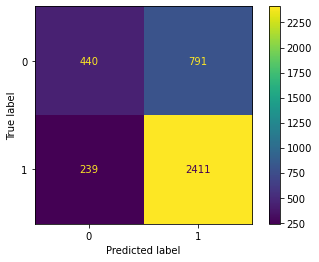

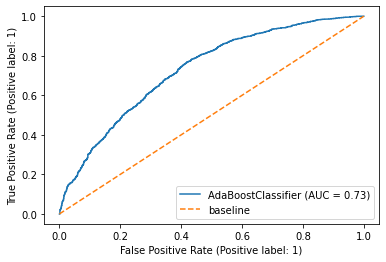

In [254]:
%%time
model = meta_func (
    model=AdaBoostClassifier(random_state=42)
,
    model_name='abc_1st_round',
    param_grid=
{
    'n_estimators': [150,300], 
    'learning_rate': [1, 2]
    }
,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    score_dict= score_dict_pedestrians
)

In [255]:
pd_features = pd.DataFrame({'Features': X_train.columns,'Coef_': model.best_estimator_.feature_importances_})
pd_features.sort_values(by='Coef_', ascending=False)

,Features,Coef_
3,hour,0.113333
2,month,0.056667
136,vehi_grp_4_wheels,0.056667
4,speed_group,0.036667
33,vehicule_type_scoot_blw_125,0.036667
...,...,...
15,pedestrian_action_playing_running,0.000000
110,weather_other,0.000000
101,crossing_others,0.000000
57,was_doing_crossing_central_separator,0.000000


#### XGBoost

Fitting 3 folds for each of 8 candidates, totalling 24 fits
best params : {'learning_rate': 0.5, 'max_depth': 3, 'min_split_loss': 2}
Test_f1_score : 0.8277032761840096
Test_precision score : 0.7522369639000308
Test_accuracy score : 0.7384694666323113
Test_recall score : 0.92
Test_roc_auc score : 0.633842404549147
CPU times: total: 14.9 s
Wall time: 31 s


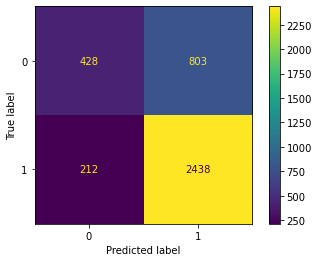

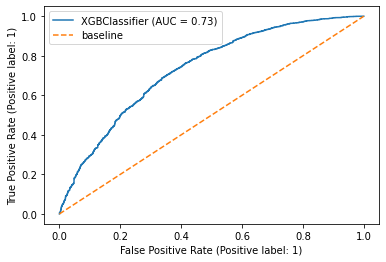

In [256]:
%%time
model = meta_func (
    model=XGBClassifier(random_state=42)
,
    model_name='xgb_1st_round',
    param_grid=
{
    'learning_rate': [0.5,1], 
    'min_split_loss': [1,2], #The larger gamma is, the more conservative the algorithm will be
    'max_depth':[2,3] #Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.
     # Beware that XGBoost aggressively consumes memory when training a deep tree
    }
,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    score_dict= score_dict_pedestrians
)

In [257]:
pd_features = pd.DataFrame({'Features': X_train.columns,'Coef_': model.best_estimator_.feature_importances_})
pd_features.sort_values(by='Coef_', ascending=False)

,Features,Coef_
0,road_num,0.184742
76,road_type_urban_rd,0.072971
33,vehicule_type_scoot_blw_125,0.063757
4,speed_group,0.057355
141,age_group_80_over,0.051387
...,...,...
75,road_type_unpaved_rd,0.000000
84,road_curve_s_curve,0.000000
88,road_surface_others,0.000000
89,road_surface_snow_ice,0.000000


#### Linear Support Vectors Classifiers

Fitting 3 folds for each of 24 candidates, totalling 72 fits
best params : {'lsvc__C': 0.01, 'lsvc__dual': False, 'lsvc__max_iter': 500, 'lsvc__penalty': 'l1'}
Test_f1_score : 0.7561316051844467
Test_precision score : 0.8016913319238901
Test_accuracy score : 0.6848750322081938
Test_recall score : 0.7154716981132075
Test_roc_auc score : 0.6672403169688703
CPU times: total: 2.2 s
Wall time: 54.9 s


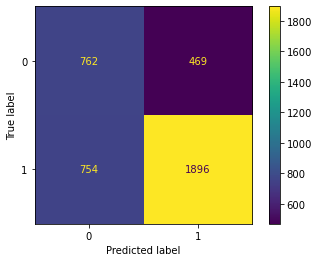

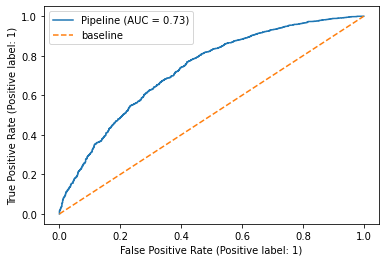

In [258]:
%%time
model = meta_func (
    model=Pipeline(
        [
            ('ss',StandardScaler()),
            ('lsvc', LinearSVC(class_weight='balanced'))
        ]
    ),
    model_name='lsvc_1st_round',
    param_grid=
{   'lsvc__max_iter':[500,1000],
    'lsvc__C': [0.001,0.01,0.1], 
    'lsvc__dual': [True, False],     
    'lsvc__penalty':['l1','l2']   
},
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    score_dict= score_dict_pedestrians
)

In [259]:
pd_features = pd.DataFrame({'Features': X_train.columns,'Coef_': model.best_estimator_.steps[-1][1].coef_[0]})
pd_features.sort_values(by='Coef_', ascending=False)

,Features,Coef_
0,road_num,0.098881
76,road_type_urban_rd,0.077230
7,pedestrian_loc_on_cross_road_lit,0.066586
69,was_doing_turning,0.065207
78,travelling_direction_unidirectional,0.052955
...,...,...
99,light_conditions_night,-0.062919
137,vehi_grp_other,-0.096050
136,vehi_grp_4_wheels,-0.158066
140,age_group_60_80,-0.173852


#### Checking our baseline models

In [260]:
pedestrians_score_df= pd.DataFrame(score_dict_pedestrians).T
pedestrians_score_df

,Train_acc,Test_acc,Train_recall,Test_recall,Train_preci,Test_preci,Train_f1score,Test_f1score,Train_roc_auc,Test_roc_auc,Train_specificity,Test_specificity
lr_1st_round,0.696392,0.683329,0.727041,0.709811,0.808884,0.803503,0.765782,0.753757,0.678749,0.668066,0.630457,0.626320
abc_1st_round,0.741624,0.734604,0.914866,0.909811,0.757206,0.752967,0.828603,0.823992,0.641900,0.633622,0.368934,0.357433
xgb_1st_round,0.751160,0.738469,0.926758,0.920000,0.760868,0.752237,0.835660,0.827703,0.650079,0.633842,0.373401,0.347685
lsvc_1st_round,0.698067,0.684875,0.733365,0.715472,0.806770,0.801691,0.768318,0.756132,0.677748,0.667240,0.622132,0.619009


### 3. Feature selection based on statistical significance - Hypothesis testing

Categorical - Continuous Split

In [261]:
df_pede.shape

(19401, 31)

In [262]:
df_pede['injury_level'] = df_pede['injury_level'].map({1:'OK',0:'not_ok'})

In [263]:
# subsetting categorical and continuous features to run chi-square test
pede_cat = df_pede.select_dtypes(include=['object'])
pede_cont = df_pede.select_dtypes(include=['int64','float64'])

In [264]:
print(pede_cat.shape)
print(pede_cont.shape)

(19401, 26)
(19401, 5)


In [265]:
# subsetting continuous features to run anova/KS test
pede_cont.head(1)


,road_num,num_operating_lanes,month,hour,speed_group
26,0.0,3,11,13,3.0


In [266]:
# joining response variable, injury_level, into continuous features dataframe
injury_level_serie = pede_cat[['injury_level']]
pede_cont = pede_cont.join(injury_level_serie)
print(pede_cont.shape)
pede_cont.head()

(19401, 6)


,road_num,num_operating_lanes,month,hour,speed_group,injury_level
26,0.0,3,11,13,3.0,OK
34,0.0,1,11,8,3.0,OK
36,0.0,1,11,9,3.0,OK
37,0.0,1,11,6,2.0,OK
44,0.0,7,11,8,3.0,OK


#### Categorical features selection<br>
Pick statistically significant features

In [267]:
# label encoding for categorical features with more than 2 values
label_encoder = LabelEncoder()

cat_train_transformed_dict = {}

for col in pede_cat.columns:
    cat_train_transformed = label_encoder.fit_transform(pede_cat[col])
    cat_train_transformed_dict[col] = cat_train_transformed
    
cat_train_transformed = pd.DataFrame(cat_train_transformed_dict)
print(cat_train_transformed.shape)
cat_train_transformed.head()

(19401, 26)


,user_type,injury_level,gender,pedestrian_loc,pedestrian_action,pedestrian_group,navigation_direction,vehicule_type,mobile_obstacle_hurt,impact_location,...,road_location_accident,light_conditions,in_out_city,crossing,weather,collision_type,day_of_week,event,vehi_grp,age_group
0,0,0,1,0,0,0,2,2,1,1,...,3,0,0,0,5,1,4,11,1,2
1,0,0,0,1,0,0,0,12,1,0,...,3,0,0,0,5,1,0,11,0,3
2,0,0,0,0,0,0,2,2,1,6,...,3,0,0,0,7,1,0,11,1,1
3,0,0,1,0,0,0,0,2,1,0,...,3,0,0,0,5,1,0,11,1,0
4,0,0,1,0,0,0,0,1,1,2,...,3,0,0,0,5,1,0,11,2,1


In [268]:
# chi-square test
X = cat_train_transformed.drop('injury_level',axis=1)
y = cat_train_transformed['injury_level']

chi_scores = chi2(X,y)

# top correlated features + p_values visualization from chi-square test
p_values = pd.Series(chi_scores[1],index = X.columns)
p_values.sort_values(inplace = True)

fig=px.bar(p_values, labels={'value': 'p_value'}, width=600, height=500)
fig.add_hline(y=0.05, line_dash="dash", line_color="red")
fig.update_layout(showlegend=False)
fig.update_xaxes(tickangle = 90)

In [269]:
# top correlated features + p_values converted to dataframe for top features list extraction
cat_pvals_df = pd.DataFrame(p_values, columns=['p_value'])
cat_pvals_df.sort_values(by = 'p_value',ascending=False).head()

,p_value
collision_type,0.950256
event,0.837177
was_doing,0.474422
crossing,0.438061
mobile_obstacle_hurt,0.322150


In [270]:
# list of top correlated categorical features
top_cat_features_list = cat_pvals_df[cat_pvals_df['p_value']<0.05].index.to_list()
top_cat_features_list
print(len(top_cat_features_list))

18


We get our categorical features to include in our 2nd round

In [271]:
# for col in top_cat_features_list:
#     injury_summary = pd.crosstab(pede_cat[col], pede_cat['injury_level'])
#     injury_summary['Total'] = injury_summary['OK'] + injury_summary['not_ok']
#     injury_summary['ok_pct'] = (injury_summary['OK']*100)/injury_summary['Total']
#     display(injury_summary[['OK', 'not_ok', 'ok_pct']].style.background_gradient(cmap='Reds'))

#### Continuous features selection
1. Pick non-correlated features
2. If 2 columns are correlated, pick the column with better statistical significance

In [272]:
# extracting all continuous feature column
pede_cont_columns = [col for col in pede_cont if col not in ['injury_level']]
print(len(pede_cont_columns))
pede_cont_columns

5


['road_num', 'num_operating_lanes', 'month', 'hour', 'speed_group']

In [273]:
# running normality and statistical significance tests on continuous features

results_dict = {col:cont_stat_sig_test(pede_cont,col) for col in pede_cont_columns}
cont_stat_results_df = pd.DataFrame.from_dict(results_dict, orient='index', columns=['p_value']).sort_values(by='p_value')

fig=px.bar(cont_stat_results_df, labels={'value': 'p_value'}, width=600, height=500)
fig.add_hline(y=0.05, line_dash="dash", line_color="red")
fig.update_layout(showlegend=False)
fig.update_xaxes(tickangle = 90)


road_num has non-normal distribution: running KS test. result: statistically significant
num_operating_lanes has non-normal distribution: running KS test. result: statistically significant
month has non-normal distribution: running KS test. result: statistically significant
hour has non-normal distribution: running KS test. result: statistically significant
speed_group has non-normal distribution: running KS test. result: statistically significant


All our continuous features are statistically significant in predicting severity of an accident

In [274]:
# rearranging pede_cont dataset's feature columns in the order of statistical significance
pede_cont = pede_cont[['injury_level']+cont_stat_results_df.index.tolist()]
cont_feature_cols = pede_cont.columns.tolist()
cont_feature_cols.remove('injury_level')
print(pede_cont.shape)
pede_cont.head()

(19401, 6)


,injury_level,road_num,speed_group,num_operating_lanes,hour,month
26,OK,0.0,3.0,3,13,11
34,OK,0.0,3.0,1,8,11
36,OK,0.0,3.0,1,9,11
37,OK,0.0,2.0,1,6,11
44,OK,0.0,3.0,7,8,11


In [275]:
# heatmap to visualize correlated features
pearson_corr_features = pede_cont.corr()
corr_data = np.tril(pearson_corr_features,k=-1)
corr_data = abs(corr_data)>0.90

fig = px.imshow(corr_data, x=pearson_corr_features.columns, y=pearson_corr_features.index,
                color_continuous_scale=px.colors.qualitative.Plotly, width=800, height=800,
                title="heat map: continuous feature correlations with >0.9 correlation coefficient")
fig.update(layout_coloraxis_showscale=False)
fig.show()


No correlation

In [276]:
# getting final list of features for modeling
# if 2 columns are correlated (yellow color), pick the column with better statistical significance
index_list = [idx for idx,row in enumerate(corr_data) if np.sum(row)>0]
print(index_list)

top_cont_feature_list = [col for idx, col in enumerate(cont_feature_cols) if idx not in index_list]
print(top_cont_feature_list)


[]
['road_num', 'speed_group', 'num_operating_lanes', 'hour', 'month']


### Model evaluation post features selection

In [277]:
train_feature_sel = df_pede[top_cont_feature_list + top_cat_features_list + ['injury_level']]
print(train_feature_sel.shape)
train_feature_sel.head()

(19401, 24)


,road_num,speed_group,num_operating_lanes,hour,month,age_group,in_out_city,road_type,travelling_direction,vehicule_type,...,pedestrian_loc,impact_location,road_incline,road_surface,navigation_direction,weather,road_curve,gender,road_location_accident,injury_level
26,0.0,3.0,3,13,11,26_60,in_city,urban_rd,bidirectional,car,...,jaywalking,front_left,flat,normal,postal_address_PR,normal,straight_line,m,road,OK
34,0.0,3.0,1,8,11,60_80,in_city,urban_rd,unidirectional,scoot_blw_125,...,on_cross_road_dark,front,flat,normal,no_marking,normal,straight_line,f,road,OK
36,0.0,3.0,1,9,11,18_25,in_city,urban_rd,unidirectional,car,...,jaywalking,rear_right,flat,normal,postal_address_PR,overcast,straight_line,f,road,OK
37,0.0,2.0,1,6,11,0_18,in_city,urban_rd,unidirectional,car,...,jaywalking,front,flat,normal,no_marking,normal,straight_line,m,road,OK
44,0.0,3.0,7,8,11,18_25,in_city,urban_rd,bidirectional,bus,...,jaywalking,front_right,flat,normal,no_marking,normal,straight_line,m,road,OK


### 4. Rerunning models

#### Logistic Regression

In [278]:
#encoding
X = train_feature_sel.drop(columns='injury_level')
X = pd.get_dummies(X, columns=X.select_dtypes('object').columns, drop_first=True)
y=train_feature_sel[['injury_level']]
y['injury_level']= y['injury_level'].map({'OK':1,'not_ok':0})
X_train,X_test,y_train,y_test = train_test_split(X, y,random_state=42, test_size=0.2, stratify=y)

In [279]:
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train) 
X_test_ss= ss.transform(X_test)

In [280]:
lr = LogisticRegression(random_state=42, solver='saga', penalty='l1', class_weight='balanced', C=0.2)

In [281]:
lr.fit(X_train_ss,y_train)

LogisticRegression(C=0.2, class_weight='balanced', penalty='l1',
                   random_state=42, solver='saga')

In [282]:
preds = lr.predict(X_test_ss)
train_preds = lr.predict(X_train_ss)


best params : <bound method BaseEstimator.get_params of LogisticRegression(C=0.2, class_weight='balanced', penalty='l1',
                   random_state=42, solver='saga')>
Test_f1_score : 0.7534659433393611
Test_precision score : 0.8057584873227331
Test_accuracy score : 0.68384437000773
Test_recall score : 0.7075471698113207
Test_roc_auc score : 0.6701830081388043


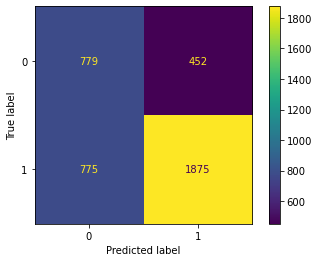

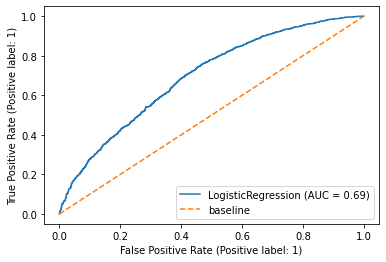

In [283]:
#getting the test metrics ready
test_f1score=f1_score(y_test,preds)
test_precision=precision_score(y_test,preds)
test_accuracy=accuracy_score(y_test,preds)
test_recall=recall_score(y_test,preds)
test_roc_auc=roc_auc_score(y_test,preds)
test_specificity = specificity_score(y_test,preds)

#getting the train metrics
train_f1score=f1_score(y_train,train_preds)
train_specificity = specificity_score(y_train,train_preds)
train_precision=precision_score(y_train,train_preds)
train_accuracy=accuracy_score(y_train,train_preds)
train_recall=recall_score(y_train,train_preds)
train_roc_auc=roc_auc_score(y_train,train_preds)
#printing results-----------------------------------------------------------------

print(f'best params : {lr.get_params}')

print(f'Test_f1_score : {test_f1score}')
print(f'Test_precision score : {test_precision}')
print(f'Test_accuracy score : {test_accuracy}')
print(f'Test_recall score : {test_recall}')
print(f'Test_roc_auc score : {test_roc_auc}')
        
# #update various metrics onto results list-------------------------------------------------------------
score_dict_pedestrians['lr_2nd_round'] = {
        'Train_acc':train_accuracy,
        'Test_acc':test_accuracy,
        'Train_recall':train_recall,
        'Test_recall':test_recall,
        'Train_preci':train_precision,
        'Test_preci':test_precision,
        'Train_f1score':train_f1score,
        'Test_f1score':test_f1score,
        'Train_roc_auc':train_roc_auc,
        'Test_roc_auc':test_roc_auc,
        'Train_specificity': train_specificity,
        'Test_specificity':test_specificity
        }

tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
cm = confusion_matrix(y_test,preds)
displ = ConfusionMatrixDisplay(cm)
displ.plot();

plot_roc_curve(lr, X_test, y_test)
plt.plot([0, 1], [0, 1],
label='baseline', linestyle='--') # to simulate random guess 
plt.legend();

In [284]:
pd_features = pd.DataFrame({'features_name':X_train.columns, 'coefs':lr.coef_[0]})
pd_features.sort_values(by='coefs', ascending=False)

,features_name,coefs
0,road_num,0.263024
49,pedestrian_loc_on_cross_road_lit,0.206736
15,road_type_urban_rd,0.147845
17,travelling_direction_unidirectional,0.140193
76,weather_light_rain,0.119868
...,...,...
25,vehicule_type_moto,-0.182967
47,vehi_grp_other,-0.185812
46,vehi_grp_4_wheels,-0.285990
7,age_group_60_80,-0.382689


#### Adaboost

Fitting 3 folds for each of 4 candidates, totalling 12 fits
best params : {'learning_rate': 1, 'n_estimators': 300}
Test_f1_score : 0.8228259012472237
Test_precision score : 0.751795192007493
Test_accuracy score : 0.7328008245297604
Test_recall score : 0.9086792452830189
Test_roc_auc score : 0.631431417929893
CPU times: total: 10.4 s
Wall time: 40.1 s


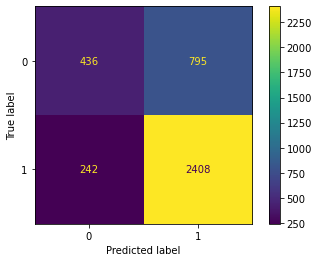

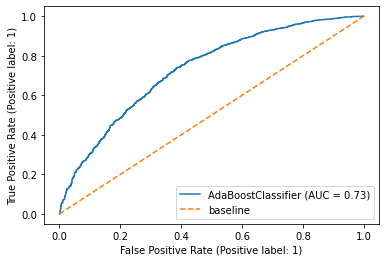

In [285]:
%%time
model = meta_func (
    model=AdaBoostClassifier(random_state=42)
,
    model_name='abc_2nd_round',
    param_grid=
{
    'n_estimators': [150,300], 
    'learning_rate': [1, 2]
    }
,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    score_dict= score_dict_pedestrians
)

In [286]:
pd_features = pd.DataFrame({'Features': X_train.columns,'Coef_': model.best_estimator_.feature_importances_})
pd_features.sort_values(by='Coef_', ascending=False)

,Features,Coef_
3,hour,0.136667
4,month,0.076667
46,vehi_grp_4_wheels,0.056667
87,road_location_accident_road,0.043333
2,num_operating_lanes,0.043333
...,...,...
26,vehicule_type_others,0.000000
10,road_type_highway,0.000000
50,pedestrian_loc_on_road_side,0.000000
52,pedestrian_loc_parrallel_road,0.000000


#### XGBoost

Fitting 3 folds for each of 8 candidates, totalling 24 fits
best params : {'learning_rate': 0.5, 'max_depth': 2, 'min_split_loss': 1}
Test_f1_score : 0.8240693523712392
Test_precision score : 0.7497680173213733
Test_accuracy score : 0.7333161556299923
Test_recall score : 0.9147169811320754
Test_roc_auc score : 0.6287638520607575
CPU times: total: 8.72 s
Wall time: 20.1 s


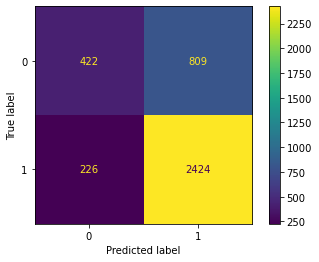

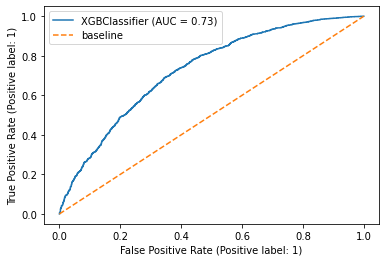

In [287]:
%%time
model = meta_func (
    model=XGBClassifier(random_state=42)
,
    model_name='xgb_2nd_round',
    param_grid=
{
    'learning_rate': [0.5,1], 
    'min_split_loss': [1,2], #The larger gamma is, the more conservative the algorithm will be
    'max_depth':[2,3] #Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.
     # Beware that XGBoost aggressively consumes memory when training a deep tree
    }
,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    score_dict= score_dict_pedestrians
)

In [288]:
pd_features = pd.DataFrame({'Features': X_train.columns,'Coef_': model.best_estimator_.feature_importances_})
pd_features.sort_values(by='Coef_', ascending=False)

,Features,Coef_
0,road_num,0.134913
15,road_type_urban_rd,0.127026
8,age_group_80_over,0.078355
1,speed_group,0.062101
17,travelling_direction_unidirectional,0.055207
...,...,...
40,pedestrian_action_same_direction_as_vehicule,0.000000
26,vehicule_type_others,0.000000
12,road_type_other_rd,0.000000
52,pedestrian_loc_parrallel_road,0.000000


#### Linear Support Vectors Classifiers

Fitting 3 folds for each of 24 candidates, totalling 72 fits
best params : {'lsvc__C': 0.001, 'lsvc__dual': True, 'lsvc__max_iter': 500, 'lsvc__penalty': 'l2'}
Test_f1_score : 0.7518072289156627
Test_precision score : 0.8034334763948497
Test_accuracy score : 0.6815253800566864
Test_recall score : 0.7064150943396227
Test_roc_auc score : 0.6671799273485278
CPU times: total: 1.06 s
Wall time: 28.4 s


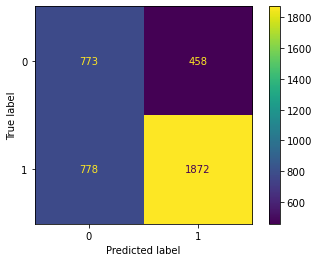

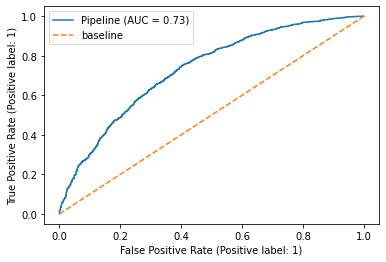

In [289]:
%%time
model = meta_func (
    model=Pipeline(
        [
            ('ss',StandardScaler()),
            ('lsvc', LinearSVC(class_weight='balanced'))
        ]
    ),
    model_name='lsvc_2nd_round',
    param_grid=
{   'lsvc__max_iter':[500,1000],
    'lsvc__C': [0.001,0.01,0.1], 
    'lsvc__dual': [True, False],     
    'lsvc__penalty':['l1','l2']   
},
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    score_dict= score_dict_pedestrians
)

In [290]:
pd_features = pd.DataFrame({'Features': X_train.columns,'Coef_': model.best_estimator_.steps[-1][1].coef_[0]})
pd_features.sort_values(by='Coef_', ascending=False)

,Features,Coef_
0,road_num,0.098936
49,pedestrian_loc_on_cross_road_lit,0.084309
17,travelling_direction_unidirectional,0.059256
15,road_type_urban_rd,0.054779
76,weather_light_rain,0.049062
...,...,...
20,vehicule_type_car,-0.062534
45,light_conditions_night,-0.068358
46,vehi_grp_4_wheels,-0.094650
7,age_group_60_80,-0.157799


In [291]:
pedestrians_score_df= pd.DataFrame(score_dict_pedestrians).T
pedestrians_score_df.sort_values(by= 'Test_specificity', ascending=False)

,Train_acc,Test_acc,Train_recall,Test_recall,Train_preci,Test_preci,Train_f1score,Test_f1score,Train_roc_auc,Test_roc_auc,Train_specificity,Test_specificity
lr_2nd_round,0.693557,0.683844,0.725248,0.707547,0.806381,0.805758,0.763665,0.753466,0.675314,0.670183,0.625381,0.632819
lsvc_2nd_round,0.694137,0.681525,0.727985,0.706415,0.805283,0.803433,0.764685,0.751807,0.674652,0.667180,0.621320,0.627945
lr_1st_round,0.696392,0.683329,0.727041,0.709811,0.808884,0.803503,0.765782,0.753757,0.678749,0.668066,0.630457,0.626320
lsvc_1st_round,0.698067,0.684875,0.733365,0.715472,0.806770,0.801691,0.768318,0.756132,0.677748,0.667240,0.622132,0.619009
abc_1st_round,0.741624,0.734604,0.914866,0.909811,0.757206,0.752967,0.828603,0.823992,0.641900,0.633622,0.368934,0.357433
abc_2nd_round,0.735825,0.732801,0.913733,0.908679,0.752390,0.751795,0.825249,0.822826,0.633415,0.631431,0.353096,0.354184
xgb_1st_round,0.751160,0.738469,0.926758,0.920000,0.760868,0.752237,0.835660,0.827703,0.650079,0.633842,0.373401,0.347685
xgb_2nd_round,0.744588,0.733316,0.920812,0.914717,0.757395,0.749768,0.831147,0.824069,0.643147,0.628764,0.365482,0.342811


In [292]:
#exporting scoring file to AWS S3
bucket = aws_creds.bucket # already created on S3
csv_buffer = StringIO()
pedestrians_score_df.to_csv(csv_buffer)
s3_resource = boto3.resource('s3')
s3_resource.Object(bucket, 'pedestrians_scores.csv').put(Body=csv_buffer.getvalue()) 

{'ResponseMetadata': {'RequestId': '26WZANNK0S628X2S',
  'HostId': 'NfQKwz07MkyOuSYwfdoSAEEmSuvZXUjx0D9eQAdOPYiGWNHQZ1YM+HBuXG4wDxdF6NfWlezcHyU=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'NfQKwz07MkyOuSYwfdoSAEEmSuvZXUjx0D9eQAdOPYiGWNHQZ1YM+HBuXG4wDxdF6NfWlezcHyU=',
   'x-amz-request-id': '26WZANNK0S628X2S',
   'date': 'Thu, 08 Dec 2022 07:30:31 GMT',
   'etag': '"13ccaecdd3bd85d72e26e817d79dc531"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 1},
 'ETag': '"13ccaecdd3bd85d72e26e817d79dc531"'}

In [ ]:
et = time.time() # end time
elapsed_time = et - st
print('Execution time:', elapsed_time/60, 'minutes')